# Import required packages

In [ ]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset

import matplotlib.pyplot as plt
import numpy as np

# Set parameters for Active Learning

In [ ]:
# Select the value for k, where top k most uncertain predictions will be relabelled from human input
least_confident_instances = 3

# Select the number of re (labelling + training) rounds
num_annotation_rounds = 2

# Load the dataset

In [ ]:
# Load the CIFAR-10 dataset
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [ ]:
# Split the dataset into an initial labeled set and an unlabeled set
labeled_set, unlabeled_set = random_split(dataset, [1000, len(dataset)-1000])

# Model initialization and helper functions

In [ ]:
# Define the model, loss function, and optimizer
model = torchvision.models.resnet18(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Function for training the model
def train_model(model, dataloader, criterion, optimizer):
    model.train()
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Active learning helper functions

In [ ]:
def transform_image(image):
    # Min-max scaling to transform image tensor from -1 to 1 to 0 to 1
    image_min = np.min(image)
    image_max = np.max(image)
    transformed_image = (image - image_min) / (image_max - image_min)
    return transformed_image

# Function for requesting new labels from a human annotator
def request_new_labels(unlabeled_set, model_predicted_labels, indices):
    new_labels = []
    for idx in indices:
        img, gt = unlabeled_set[idx]
        img = img.permute(1, 2, 0)
        print()
        plt.imshow(transform_image(img.numpy()))
        plt.show()
        print(f"Model predicted label = {model_predicted_labels[idx]}\nGround truth label = {gt}")
        label = input("Please enter the label for this image: ")
        new_labels.append(int(label))
    return torch.tensor(new_labels)

In [ ]:
class LabeledDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

    def __len__(self):
        return len(self.data)

# Active learning training loop


Starting annotation round 1...
Training model on labeled set with 1000 instances...
Making predictions on unlabeled set with 49000 instances...
Selected 3 instances with lowest model confidence for annotation...
Requesting new labels...


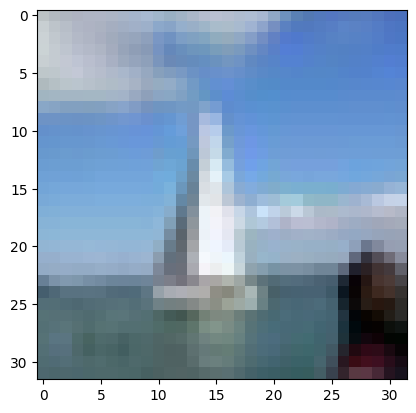

Model predicted label = 2
Ground truth label = 8
Please enter the label for this image: 8


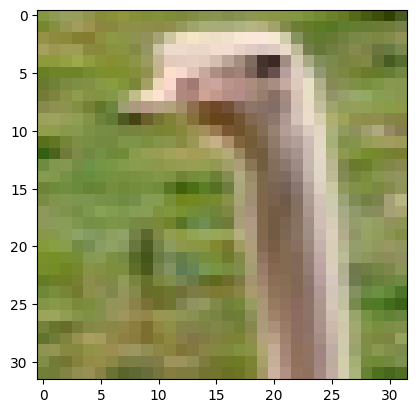

Model predicted label = 3
Ground truth label = 2
Please enter the label for this image: 2


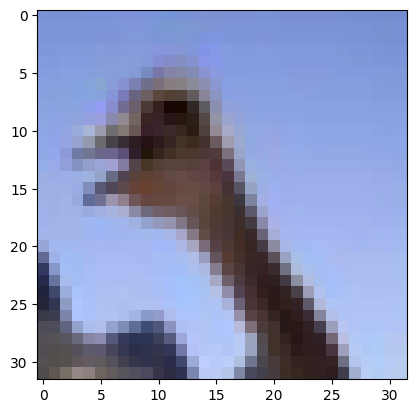

Model predicted label = 2
Ground truth label = 2
Please enter the label for this image: 2
Added 3 newly labeled instances to labeled set.
Removed newly labeled instances from unlabeled set. 48997 instances remaining.

Starting annotation round 2...
Training model on labeled set with 1003 instances...
Making predictions on unlabeled set with 48997 instances...
Selected 3 instances with lowest model confidence for annotation...
Requesting new labels...


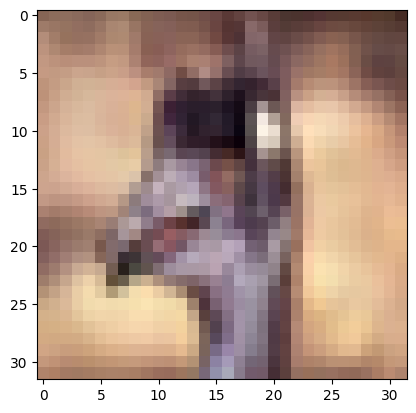

Model predicted label = 5
Ground truth label = 2
Please enter the label for this image: 2


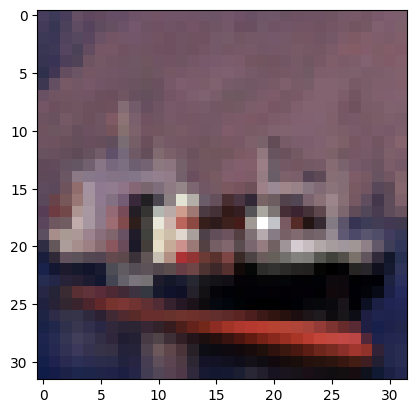

Model predicted label = 2
Ground truth label = 8
Please enter the label for this image: 8


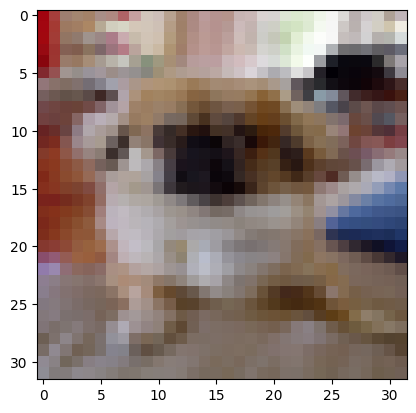

Model predicted label = 4
Ground truth label = 5
Please enter the label for this image: 5
Added 3 newly labeled instances to labeled set.
Removed newly labeled instances from unlabeled set. 48994 instances remaining.

Training model on final labeled set with 1006 instances...


Active learning process completed.


In [ ]:
# Active learning loop
for iteration in range(num_annotation_rounds):
    print(f"\nStarting annotation round {iteration + 1}...")

    # Train the model on the labeled set
    dataloader = DataLoader(labeled_set, batch_size=128, shuffle=True)
    print(f"Training model on labeled set with {len(labeled_set)} instances...")
    train_model(model, dataloader, criterion, optimizer)

    # Use the trained model to make predictions on the unlabeled set
    dataloader = DataLoader(unlabeled_set, batch_size=128)
    predictions = []
    print(f"Making predictions on unlabeled set with {len(unlabeled_set)} instances...")
    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            outputs = model(inputs)
            predictions.extend(outputs.softmax(dim=-1))
            if i ==3:
                break

    predictions_matrix = torch.stack(predictions)

    # Select the instances where the model is least confident
    probabilities, model_predicted_labels = torch.max(predictions_matrix, dim=1)
    uncertainty_scores = 1.0 - probabilities
    _, indices = torch.topk(uncertainty_scores, k=least_confident_instances)  # select top k least confident instances
    print(f"Selected {len(indices)} instances with lowest model confidence for annotation...")

    # Request new labels for the instances where the model is least confident
    print("Requesting new labels...")
    new_labels = request_new_labels(unlabeled_set, model_predicted_labels, indices)


    # Create a new LabeledDataset with the newly labeled instances
    new_data = [unlabeled_set[i][0] for i in indices.tolist()]
    new_labeled_set = LabeledDataset(new_data, new_labels)

    # Add the newly labeled instances to the labeled set
    labeled_set = torch.utils.data.ConcatDataset([labeled_set, new_labeled_set])

    print(f"Added {len(new_labeled_set)} newly labeled instances to labeled set.")

    # Remove the newly labeled instances from the unlabeled set
    unlabeled_set = Subset(unlabeled_set, list(set(range(len(unlabeled_set))) - set(indices.tolist())))

    print(f"Removed newly labeled instances from unlabeled set. {len(unlabeled_set)} instances remaining.")

# Train the model on the labeled set
dataloader = DataLoader(labeled_set, batch_size=128, shuffle=True)
print(f"\nTraining model on final labeled set with {len(labeled_set)} instances...")
train_model(model, dataloader, criterion, optimizer)
print("\n\nActive learning process completed.")

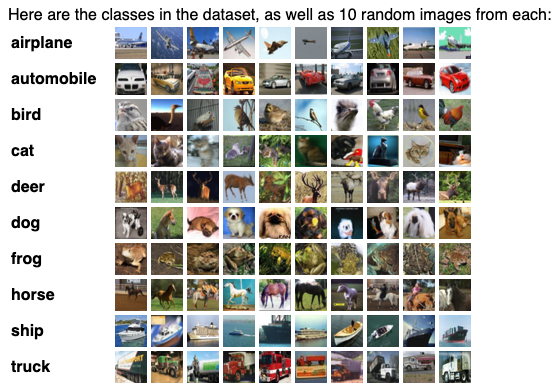